# A Guide to Predicting Allstate Claims Severity

Insurers are accustomed to working with large amounts of data to assess risk.  But the industry has been slow to adopt new technology to help reduce costs and improve efficiency.  Despite it risk-averse culture, it seems as though insurance companies are beginning to view machine learning as a game-changer.  Allstate, one of the biggest insurance companies in America, recently reached out to the Kaggle community in hopes of improving their claims service.  And I was up for the challenge.  In this notebook, you will get to see how I used machine learning to automate the methods of predicting the cost, and hence the severity of Allstate claims.  

## Why Attempt this Project?  

* It was a recruitment challenge, where Allstate would potentially interview the top performers.

* To explain how I achieved a top 28% ranking on the public leaderboard.  Hopefully, you will be encouraged to attempt a Kaggle challenge on your own. 

* The fields were anonymized and I thought it would be good to see how well I could do with incomplete information.  

## The Challenge

Allstate is working on automating its claims service.  My goal was to predict the severity of claims on the provided data.  This is a supervised learning problem.

## Project Structure

1. Explore the Data
    - A look at Data Types
    - Check for Missing Values
    - Check for Unique Values
    - Data Visualizations
2. Data Pre-processing
    - Handle Categorical Data
3. The Mean Absolute Error Metric
4. Partition the Data Set
5. Establish Benchmark Results
6. Model Selection
7. Model Fine-Tuning
8. Prepare First Submission
9. Stacking
    - Architecture
    - How it Works
    - Coding it
    - Model Selection
    - Neural Networks
10. Prepare Final Submission
11. Conclusion

## Explore the Data

To get started, I first read in the [data](https://www.kaggle.com/c/allstate-claims-severity/data).  If you feel like working along, you can download the `train.csv` and the `test.csv` files.  These files contain the training and test data sets that you will use for this project.  There is also a `sample_submission.csv` file, which is a template showing how the submitted file should be structured.  Let's first take a look at the `sample_submission.csv` file.

In [2]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 200
from IPython.display import display

# I stored my data files in a folder called 'data'
directory = 'data/'

# preview sample submission file
sample_file = pd.read_csv(directory + "sample_submission.csv")
print("\n Sample submission File contains {} rows and {} columns".format(sample_file.shape[0], sample_file.shape[1]))
print(sample_file.head())


 Sample submission File contains 125546 rows and 2 columns
   id  loss
0   4     0
1   6     0
2   9     0
3  12     0
4  15     0


The `sample_submission` file contains 125, 546 rows.  The model's final output should consist of an equal number of elements.  The `loss` column in the `sample_submission` file contains zeroes, but our final submission file replaced those zeroes with the predicted loss per claim. 

Let's take a look at the `train.csv` and `test.csv` files.  

In [5]:
# read train.csv file
train = pd.read_csv(directory + "train.csv")
print("\n The training set contains {} rows and {} columns \n".format(train.shape[0], train.shape[1]))
print(train.ix[:5, :10])


 The training set contains 188318 rows and 132 columns 

   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9
0   1    A    B    A    B    A    A    A    A    B
1   2    A    B    A    A    A    A    A    A    B
2   5    A    B    A    A    B    A    A    A    B
3  10    B    B    A    B    A    A    A    A    B
4  11    A    B    A    B    A    A    A    A    B
5  13    A    B    A    A    A    A    A    A    B


In [6]:
# read test.csv file
test = pd.read_csv(directory + "test.csv")
print("\n The test set contains {} rows and {} columns \n".format(test.shape[0], test.shape[1]))
print(test.ix[:5, :10])


 The test set contains 125546 rows and 131 columns 

   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9
0   4    A    B    A    A    A    A    A    A    B
1   6    A    B    A    B    A    A    A    A    B
2   9    A    B    A    B    B    A    B    A    B
3  12    A    A    A    A    B    A    A    A    A
4  15    B    A    A    A    A    B    A    A    A
5  17    A    A    A    A    B    A    A    A    A


We can see that both training and test data sets have an `id` column, and a series of other columns containing feature variables.  The training set contains 132 columns, as opposed to the test set, which contains 131 columns.  This is because the training set contains a column titled, `loss`, our target or class label.  

Each row in the training and test set represents information pertaining to a unique claim filed with Allstate

In [6]:
# class label
loss = train['loss']
print(loss[:5])

0    2213.18
1    1283.60
2    3005.09
3     939.85
4    2763.85
Name: loss, dtype: float64


I printed the first 5 rows of data in the `loss` column.  I used the remaining columns that either begin with `cat` or `cont` as feature variables.  These feature variables contained useful information to help our model to accurately predict the loss per claim.  

### Merge Data Sets


I merged the training and test sets temporarily, because it makes it easier to analyze them when they are together.  

In [17]:
# merge datasets for exploratory purposes.  We can separate them later
frames = [train, test]
data = pd.concat(frames)
print("The combined data set contains {} rows and {} columns".format(data.shape[0], data.shape[1]))

# the label column will contain missing values after merging test and train datasets
print("There are now {} missing values in the loss column".format(data['loss'].isnull().sum()))

The combined data set contains 313864 rows and 132 columns
There are now 125546 missing values in the loss column


## Data Types

In [26]:
print(data.dtypes)

cat1       object
cat10      object
cat100     object
cat101     object
cat102     object
cat103     object
cat104     object
cat105     object
cat106     object
cat107     object
cat108     object
cat109     object
cat11      object
cat110     object
cat111     object
cat112     object
cat113     object
cat114     object
cat115     object
cat116     object
cat12      object
cat13      object
cat14      object
cat15      object
cat16      object
cat17      object
cat18      object
cat19      object
cat2       object
cat20      object
           ...   
cat87      object
cat88      object
cat89      object
cat9       object
cat90      object
cat91      object
cat92      object
cat93      object
cat94      object
cat95      object
cat96      object
cat97      object
cat98      object
cat99      object
cont1     float64
cont10    float64
cont11    float64
cont12    float64
cont13    float64
cont14    float64
cont2     float64
cont3     float64
cont4     float64
cont5     float64
cont6     

The columns that begin with `cat` are object types, and the columns that begin with `cont` are float types.  The `id` and `loss` columns are integer and floats respectively.  

In [18]:
# extract features by type
categorical_features = [col for col in data if 'cat' in col]
continuous_features = [col for col in data if 'cont' in col]

print("There are {} categorical features".format(len(categorical_features)))
print("There are {} continuous features".format(len(continuous_features)))

There are 116 categorical features
There are 14 continuous features


In this step, we identify whether each feature is a categorical or continuous variable.  This is an important step, because we typically handle these variable types in different ways.  I'll address this in the data-preprocessing section.

## Check for Missing Values

Machine learning algorithms can't function with missing values, so we have to remove them if they exist.

In [25]:
print(data.isnull().sum())

cat1           0
cat10          0
cat100         0
cat101         0
cat102         0
cat103         0
cat104         0
cat105         0
cat106         0
cat107         0
cat108         0
cat109         0
cat11          0
cat110         0
cat111         0
cat112         0
cat113         0
cat114         0
cat115         0
cat116         0
cat12          0
cat13          0
cat14          0
cat15          0
cat16          0
cat17          0
cat18          0
cat19          0
cat2           0
cat20          0
           ...  
cat87          0
cat88          0
cat89          0
cat9           0
cat90          0
cat91          0
cat92          0
cat93          0
cat94          0
cat95          0
cat96          0
cat97          0
cat98          0
cat99          0
cont1          0
cont10         0
cont11         0
cont12         0
cont13         0
cont14         0
cont2          0
cont3          0
cont4          0
cont5          0
cont6          0
cont7          0
cont8          0
cont9         

There were missing values in the loss column equal to the number of rows in the test set.  Don't worry about these for now.  When we partition the data set later on, we can drop these values from the test set.  Notice that all the other columns don't contain any missing values.

## Unique Values

We'll explore the unique values in the feature columns.  

In [11]:
cat_uniques = []
for cat in categorical_features:
    cat_uniques.append(len(data[cat].unique()))
    
unique_values = pd.DataFrame({'cat_name': categorical_features, 'unique_values': cat_uniques})
print(unique_values)

    cat_name  unique_values
0       cat1              2
1      cat10              2
2     cat100             15
3     cat101             19
4     cat102              9
5     cat103             14
6     cat104             17
7     cat105             20
8     cat106             18
9     cat107             20
10    cat108             11
11    cat109             85
12     cat11              2
13    cat110            134
14    cat111             17
15    cat112             51
16    cat113             63
17    cat114             19
18    cat115             23
19    cat116            349
20     cat12              2
21     cat13              2
22     cat14              2
23     cat15              2
24     cat16              2
25     cat17              2
26     cat18              2
27     cat19              2
28      cat2              2
29     cat20              2
..       ...            ...
86     cat72              2
87     cat73              3
88     cat74              3
89     cat75        

In [12]:
print(unique_values.describe())

       unique_values
count     116.000000
mean       10.137931
std        35.696766
min         2.000000
25%         2.000000
50%         2.000000
75%         4.000000
max       349.000000


The table above gives us an idea of the number of unique values in each column, which ranged between 2-349.

## Data Visualizations

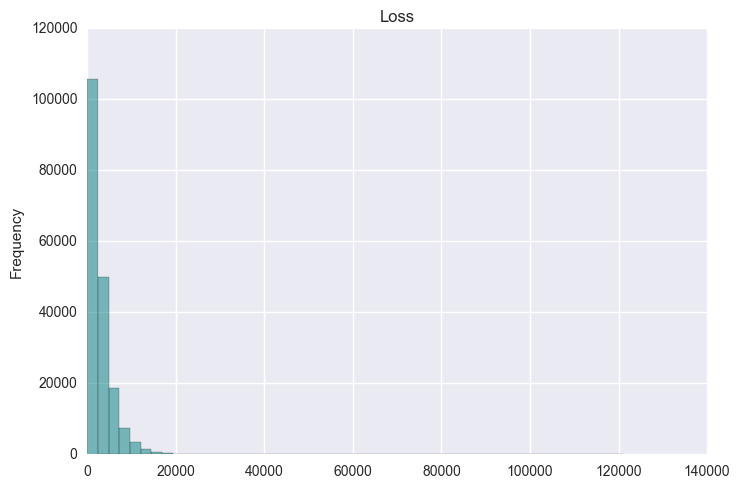

In [43]:
# Plot showing loss distribution
plt.figure()
data['loss'].plot.hist(alpha=0.5, color = 'teal', bins = 50)
plt.title("Loss")
# plt.savefig('images/loss.png')
plt.show()

This plot shows the distribution of the `loss` column.  You can see that it is skewed to the left.  Skewedness measures the asymmetry of a probability distribution of variabels about its mean.  This kind of distribution can hamper our model's ability to make accurate predictions.  I applied a log transformation to this column in the data-preprocessing section.

Now let's plot the distribution of the continuous variables.

### Plot Continuous Variables

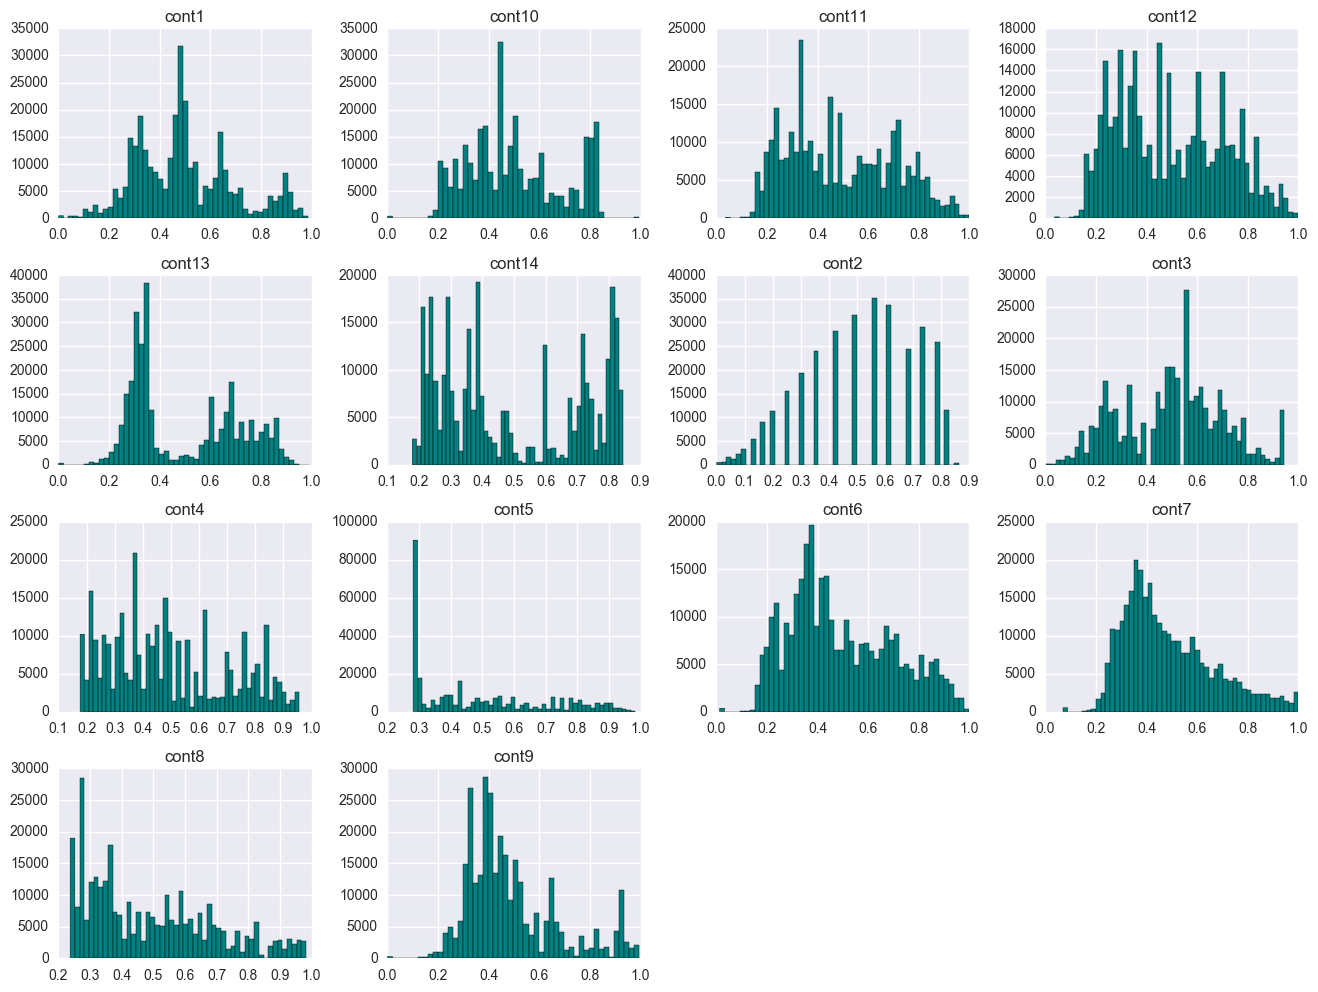

In [42]:
data[continuous_features].hist(bins=50, figsize=(16,12), color = 'teal')
# plt.savefig('images/conts.png')
plt.show()

Some of these continuous features don't have a normal distribution.  For example, `cont5` is skewed to the left.  We also see that some, like `cont12` and `cont8`, have multiple spikes.  

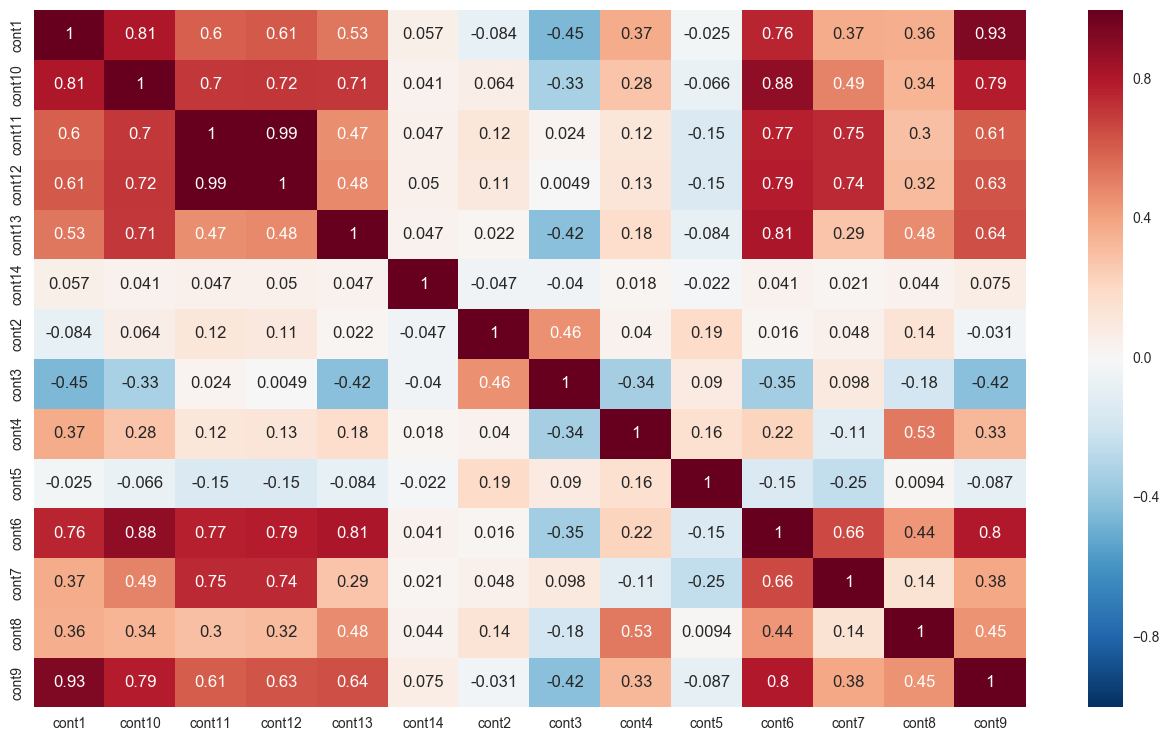

In [41]:
# Let's look at the correlation between the continuous variables
corr = data[continuous_features].corr()
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr, annot = True)
# plt.savefig('images/heatmap.png')
plt.show()

We can see that correlations exists between some of the continuous variables.  For example, the corr score between `cont10` and `cont6` is .88.  Another good example is the correlation between `cont11` and `cont12` at .99.  

Lastly, let's visualize some of the categorical columns

### Plot Categorical Variables

In [19]:
# first, we convert the categorical variables into numbers
data_copy = data.copy()
categoricals = data_copy.loc[:, categorical_features]
for cat_feat in categoricals.columns:
    categoricals[cat_feat] = pd.factorize(categoricals[cat_feat], sort=True)[0]

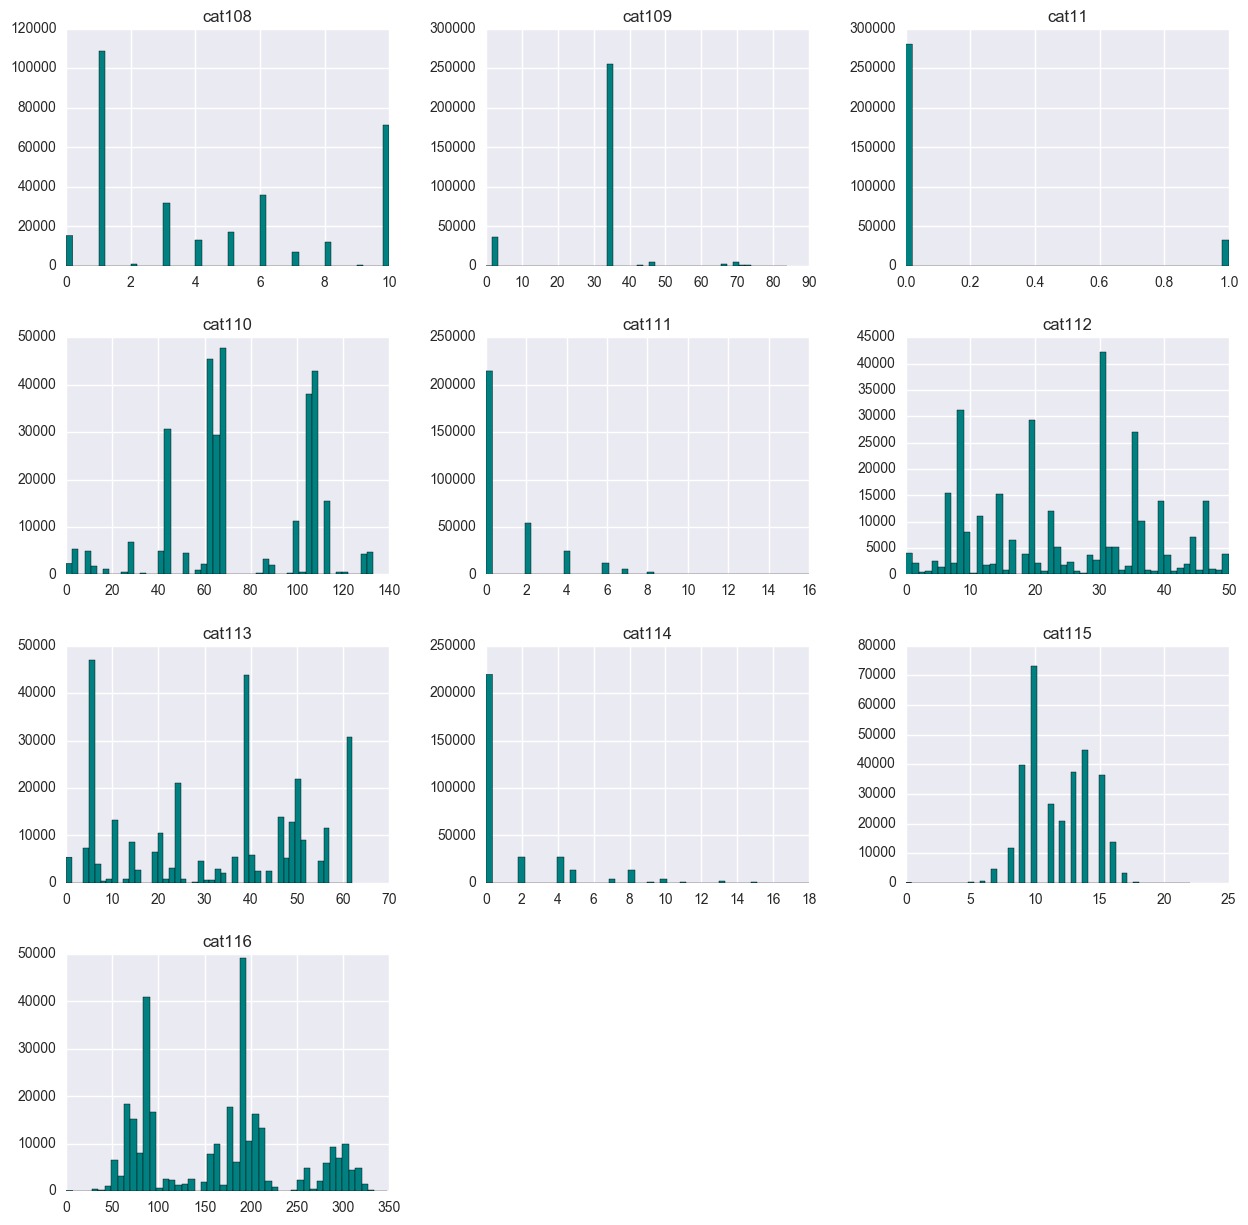

In [40]:
# plot a few columns
sample_cols = categoricals.ix[:, 10:20]
sample_cols.hist(bins = 50, figsize = (15, 15), color = 'teal')
# plt.savefig('images/cats.png')
plt.show()


In some cases, it's evident from plot samples that there is an uneven distribution between the unique values in each column.  `cat109`, `cat111`, and `cat114` are examples of this uneven distribution.  

## Data Preprocessing

This data set didn't require much processing or cleaning.  What we will need to address are the categorical variables.  Just like we did earlier to plot the sample columns, we'll apply the same technique to convert the columns to numerical features.  This should be sufficient enough to begin training a benchmark model.  I'll talk about this in a bit.  First, let's go ahead and apply the transformations on the data.

In [ ]:
for cat_feat in categorical_features:
    data_copy[cat_feat] = pd.factorize(data_copy[cat_feat], sort=True)[0]

In [32]:
# preview transformed data set    
print(data_copy.iloc[:5, [0, 1, 2, 3, 5]])

   cat1  cat10  cat100  cat101  cat103
0     0      0       1       6       0
1     0      1      11       5       0
2     0      1      11      14       1
3     1      0       8       3       0
4     0      1       5       9       0


Okay! So the categorical columns are now in a numerical format, and ready to be used for training.  For each column, we substituted each unique value with a unique integer. 

## Evaluation Metric

The models in this project were evaluated using the mean absolute error (MAE) between the predicted loss and the actual loss for each claim in the test set.  

The MAE is average of the absolute errors for all values in our test set.  See the formula below:

$$ MAE = \frac{1}{n} \sum_{i=1}^{n}\left | x_i - x \right |  $$

Where:

$n$ - the number of errors (equal to the size of our test set)

$sum$ - the sum of all errors in our test set

|$x_i - x$| - the absolute error between the predicted loss, and the actual loss

The goal was to minimize the MAE in our model's predictions.  We'll go through selecting and fine-tuning a series of models, to find which one achieves the lowest MAE.

## Partition Data Set

Before we start using machine learning models, we have to split the data into train and test sets.  We'll also apply a log transformation on the `loss` column.  Remember that the distribution for the `loss` column is skewed.  The log transformation will transform the data to make it more gaussian.  A [gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) means the data is symmetric, with a mean of zero and a standard deviation of one.  Notice that a shift was applied to the log transformation as well.  The transformed `loss` column is assigned to a new variable, `y_train`, which will be used as our target variable. 

We also store the values from the `id` column because we'll need these later when preparing our submission file.  Lastly, we drop the `id` and `loss` column from the training and test sets.

In [34]:
shift = 200

# split into training and test sets
train = data_copy[data_copy['loss'].notnull()]
test = data_copy[data_copy['loss'].isnull()]

# create target label
y_train = np.log(train['loss'] + shift)

# store ids
test_ids = test['id']

# drop columns
X_train = train.drop(['id', 'loss'], axis= 1)
X_test = test.drop(['id', 'loss'], axis = 1)

In [9]:
# Let's see the shapes of the partitioned data sets
print("X_train contains {} rows and {} columns".format(X_train.shape[0], X_train.shape[1]))
print("X_test contains {} rows and {} columns".format(X_test.shape[0], X_test.shape[1]))

X_train contains 188318 rows and 130 columns
X_test contains 125546 rows and 130 columns


I'll visualize the effect of the log and shift transformation on the `loss` column below:

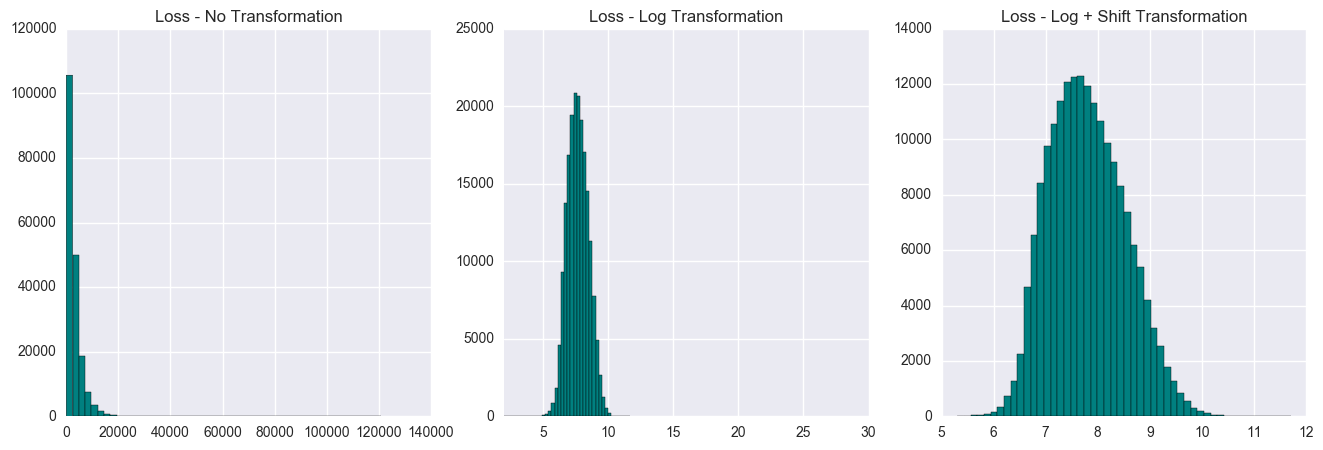

In [35]:
default_loss = train['loss']
log_loss = np.log(train['loss'])
log_shift_loss = np.log(train['loss'] + shift)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(16,5)
ax1.hist(default_loss, bins = 50, color = 'teal')
ax1.set_title('Loss - No Transformation')

ax2.set_xlim(2,30)
ax2.set_title('Loss - Log Transformation')
ax2.hist(log_loss, bins = 50, color = 'teal')

ax3.set_title('Loss - Log + Shift Transformation')
ax3.hist(log_shift_loss, bins = 50, color = 'teal')
plt.show()
# fig.savefig('images/loss.png')

The plots above show the distribution of the `loss` column before any transformations (left), and the distribution after both log and log+shift transformations respectively.  Notice that the shift gives the `loss` column a gaussian distribution. 

## Establish Benchmark Results

Now it's time to get a benchmark result.  Since the values in the `loss` column are continuous variables, we will have to apply regression based models.  Some good starter models to consider are:
* Random Forest Regressor
* Extra Trees Regressor
* Neural Networks
* Extreme Gradient Boosting(XGBoost)

If you have read about winning Kaggle competitions, you will definitely know about the strength of XGBoost.  It's widely used and is an ever-present choice for competition winners.  But we will save it for later.  I want to see how well one of the other models perform, then compare it against the XGBoost model.  

Let's start by training a Random Forest Regressor.  A Random Forest Regressor is a boosting model, made up of a number of tree stubs.  It's more powerful than a single decision tree, because it applies a method called [boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning).  Boosting works by putting emphasis on samples that are harder to predict.  By doing this, each new tree in the forest updates some associated weight of these harder to predict samples, in an effort to minimize the loss in our cost function (in our case, it's the MAE).  

### K-Folds Cross Validation

I'll use [K-Folds Cross-Validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to create my validation sets.  K-Folds Cross-validation works by splitting the training set into k number of bins.  We then train a model over k - 1 folds, using one of the bins as a test set, and the rest as our training data.  By doing this, we will get to use all of our data to act as training and test data over the k - 1 folds.  We then average the results after each fold, giving us a smooth average of how the model performs on unseen data.  In this [video](https://www.youtube.com/watch?v=TIgfjmp-4BA), [Sebastian Thurn](https://en.wikipedia.org/wiki/Sebastian_Thrun) explains how K-Folds CV works.  

We can't use the actual test set for this purpose, for two reasons:
1. We don't have the `loss` column in our test set.  Kaggle holds onto that
2. Even if we had it and opted to use it, our model would be biased towards the test set and wouldn't be able to learn on unseen data.  

Instead, we create a validation set.  The validation set is a subsample of the training set that acts as a substitute to the test set during training.  We use the validation set to gauge model performance and to fine-tune our model.  

In [31]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import time

# Used to ensure that we can replicate the results in the future 
random_state = 16

# number of folds
k = 5

In [175]:
# create instance of the Random Forest Regressor.  
rfr = RandomForestRegressor(random_state = random_state, n_jobs = -1)

def train_model(model, num_folds):
    """Train model and average the results"""
    
    print("Begin training")
    start = time.time()
    
    # declare a KFold instance
    kfold = KFold(n_splits = num_folds, random_state = random_state)
    
    # number of models
    num_models = 1
    
    # array to store results after each fold
    results = []
    
    # train K-1 Random Forests using K-Folds CV
    for i, (train, val) in enumerate(kfold.split(X_train)):
        # get smaller training set and create validation set
        X_train_mini, X_val = X_train.iloc[train], X_train.iloc[val]
        y_train_mini, y_val = y_train[train], y_train[val]

        # train Random Forest Regressor
        model.fit(X_train_mini, y_train_mini)

        # make predictions 
        preds = model.predict(X_val)
        
        # calculate mean absolute error
        error = mean_absolute_error(np.exp(y_val) - shift, np.exp(preds) - shift)
        print("MAE on fold {} is {}".format(i, error))
        
        # store result
        results.append(error)
    
    end = time.time()
    print("Training complete! Time Elapsed:", end - start)

    # get average error over k folds
    avg_error = np.mean(results)
    print(avg_error)
    
train_model(model = rfr, num_folds = k)

Begin training
MAE on fold 0 is 1263.1200132841748
MAE on fold 1 is 1259.3206200016277
MAE on fold 2 is 1270.9124101776865
MAE on fold 3 is 1267.4249098777054
MAE on fold 4 is 1254.5292425624418
Training complete! Time Elapsed: 90.12879705429077
1263.06143918


I put the training and testing in a function, because we will reuse its functionality.  Predictions were made on the validation set instead of the test set during each fold.  One thing that may confuse you is that I found the exponent of the predictions and the target labels.  I did this because finding the exponent of these arrays is the inverse of the log transformation we performed on the `loss` column/target labels earlier.  So the inverse transformation is needed to produce the result we need.  Notice that I also reversed the shift that I applied earlier as well.  

I trained the Random Forest Regressor over 5 folds, and then averaged the results to get our predictions.  Notice that on fold 0 and fold 2, the Random Forest produced comparatively worse results than on other folds.  If we didn't apply cross-validation, and partitioned our training set by using only one specific portion of the data as our validation set, we could have ended up with a lower score, like what we experienced in fold 0 or fold 2.  On the other hand, fold 4 produced the lowest MAE.  

## Model Selection

Now that we have our benchmark, it is time to beat it.  This should be easy as increasing the `n_estimators` parameter.  We will manually fine-tune the Random Forest Regressor for one more round before experimenting with other models.  

In the meantime, let's go ahead and increase the number of estimators to 30 to see how the model performs. I also set the `n_jobs` parameter to -1.  This means the number of jobs to run in parallel is set to the number of cores in your computer.  

In [159]:
rfr = RandomForestRegressor(n_estimators = 30, n_jobs = -1, random_state = random_state)
train_model(model = rfr, num_folds = k)

Begin training
MAE on fold 0 is 1224.4923321581148
MAE on fold 1 is 1220.5465977859767
MAE on fold 2 is 1230.197391841117
MAE on fold 3 is 1230.4791714766538
MAE on fold 4 is 1215.5010972235334
Training complete! Time Elapsed: 223.36082792282104
1224.2433181


We can see that increasing the number of estimators to 30 improved our score.  Now it's time to try out other models.   
Let's try the [Extra Trees Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor).  It's another tree-based model that fits randomized decision trees on subsamples of the data set.  The results are then averaged.  Let's see how this performs in comparison to the Random Forest Regressor we trained.

In [162]:
from sklearn.ensemble import ExtraTreesRegressor

# create instance of the model.  We'll use the default parameters to do a fair comparison with the Random Forest Regressor.
etr = ExtraTreesRegressor(random_state = random_state, n_jobs = -1)
train_model(model = etr, num_folds = k)

Begin training
MAE on fold 0 is 1277.7282649254016
MAE on fold 1 is 1266.765012085606
MAE on fold 2 is 1275.8031991227972
MAE on fold 3 is 1275.8808814928047
MAE on fold 4 is 1259.1975468865537
Training complete! Time Elapsed: 76.51247906684875
1271.0749809


The ExtraTreesRegressor performed slightly worse on average than the Random Forest Regressor.  Let's increase the number of estimators to 30 to see how it does

In [165]:
etr = ExtraTreesRegressor(n_estimators = 30, random_state = random_state, n_jobs = -1)
train_model(model = etr, num_folds = k)

Begin training
MAE on fold 0 is 1234.6093906647086
MAE on fold 1 is 1229.9700527588534
MAE on fold 2 is 1238.845842990506
MAE on fold 3 is 1240.4982351893314
MAE on fold 4 is 1222.3941473958178
Training complete! Time Elapsed: 214.84378695487976
1233.2635338


Let's now train an [XGBoost](http://xgboost.readthedocs.io/en/latest//) model.  I'll use the scikit-learn wrapper interface, [XGBRegressor()](http://xgboost.readthedocs.io/en/latest///python/python_api.html). 

In [168]:
xgb = XGBRegressor(silent = True, seed = random_state, nthread = -1)
train_model(model = xgb, num_folds = k)

Begin training
MAE on fold 0 is 1203.1876830136177
MAE on fold 1 is 1204.4772069705132
MAE on fold 2 is 1215.2426645268886
MAE on fold 3 is 1213.935375166477
MAE on fold 4 is 1201.8125005755583
Training complete! Time Elapsed: 57.48760008811951
1207.73108605


The XGBRegressor performed better than the previous models, even without changing any of the default parameters.  In the next section, I will fine-tune the XGBoost model.  I will add an early stopping feature, to stop training if the error on the validation set fails to decrease after a specified number of rounds.  

## Fine-Tune Model

It's better to fine-tune the model automatically, especially because there are several parameters that can be used to reduce error and overfitting.  Here is a list of the key parameters below:

* n_estimators - The number of boosted trees to fit.  
* max_depth - Max tree depth for boosted trees
* gamma - Minimum loss reduction required to make a further partition on a leaf node of the tree.
* min_child_weight - Minimum sum of instance weight(hessian) needed in a child.
* subsample - Subsample ratio of the training instance.
* colsample_bytree - Subsample ratio of columns when constructing each tree.
* alpha - L1 Regularization term on weights.

When fine-tuning the model, we have to consider the bias-variance trade-off.  For example, by increasing the number of estimators, our model can learn more about the data and improve performance, but up to a point.  Meaning, we can continue increasing the number of boosted trees till we see the effects of overfitting.  Finding the optimal number of boosted trees is the first step to fine-tuning the model. 

After we find the optimal number of boosted trees, we can begin tuning the other parameters.  I'll be using [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization) approach to do this.  [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) are also options available to us.  GridSearchCV exhaustively finds the optimal parameters for our model, but it is computationally costly.  Randomized Searching, as the name says, randomly selects combinations of parameters to find an optimal model.  But even this method takes quite some time to finish.  I find Bayesian Optimization to be quicker.  Bayesian Optimization attempts to find the optimal parameters for our model using bayesian inference in as few iterations as possible. 

As I mentioned earlier, I'll use an early stopping feature.  I'll also use a custom evaluation function.  Early stopping will be set to 50. We can set the `n_estimators` parameter to any number, since we have the early stopping feature in place.  The learning rate/eta, is 0.1 by default.  I won't change this, given that it is high enough to speed up the learning processs.  

In [11]:
# Custom eval metric
def eval_error(preds, dtrain):
    """Custom evaluation function"""
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))

In [16]:
def train_xgboost(model, num_folds, early_stopping_rounds):
    """Train model and average the results"""
    
    print("Begin training")
    start = time.time()
    
    # declare a KFold instance
    kfold = KFold(n_splits = num_folds, random_state = random_state)
    
    # number of models
    num_models = 1
    
    # array to store results after each fold
    results = []
    
    # train K-1 Random Forests using K-Folds CV
    for i, (train, val) in enumerate(kfold.split(X_train)):
        # get smaller training set and create validation set
        X_train_mini, X_val = X_train.iloc[train], X_train.iloc[val]
        y_train_mini, y_val = y_train[train], y_train[val]

        # train Random Forest Regressor
        model.fit(X_train_mini, 
                  y_train_mini,
                  eval_set = [(X_train_mini, y_train_mini), (X_val, y_val)], 
                  early_stopping_rounds = early_stopping_rounds,
                  eval_metric = eval_error,
                  verbose = False)

        # make predictions 
        preds = model.predict(X_val, ntree_limit = model.best_ntree_limit)
        
        # calculate mean absolute error
        error = mean_absolute_error(np.exp(y_val) - shift, np.exp(preds) - shift)
        print("MAE on fold {} is {}".format(i, error))
        
        # store result
        results.append(error)
        
        # best tree limit
        print("Optimal number of boosted trees on fold {} is {} \n".format(i, model.best_ntree_limit))
    
    end = time.time()
    print("Training complete! Time Elapsed:", end - start)

    # get average error over k folds
    avg_error = np.mean(results)
    print(avg_error)

In [17]:
xgb = XGBRegressor(n_estimators = 8000,
                   silent = True, 
                   seed = 16, 
                   nthread = -1)
train_xgboost(model = xgb, 
              num_folds = 5,
              early_stopping_rounds = 50)

Begin training
MAE on fold 0 is 1158.6520646758229
Optimal number of boosted trees on fold 0 is 702 

MAE on fold 1 is 1144.390127385155
Optimal number of boosted trees on fold 1 is 1505 

MAE on fold 2 is 1158.940723732857
Optimal number of boosted trees on fold 2 is 1358 

MAE on fold 3 is 1155.210151976194
Optimal number of boosted trees on fold 3 is 1328 

MAE on fold 4 is 1143.0372166497282
Optimal number of boosted trees on fold 4 is 1358 

Training complete! Time Elapsed: 707.3152899742126
1152.04605688


Adding more estimators reduces the error further.  The average validation error reduced to 1152.153.  

Now we can fine-tune parameters like max_depth, subsample, gamma etc using Bayesian Optimization.  I'll use the XGBoost without the scikit-learn wrapper in this section.  I created a function that takes in the parameters we would like to fine-tune.  Then we will use XGBoost's built-in cross-validation function to train the model.  I added an early stopping feature, to stop training if the model stops learning.     

In [13]:
from bayes_opt import BayesianOptimization
# a progress meter
from tqdm import tqdm

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['cosample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)
    


    cv_result = xgb.cv(params, 
                        xgtrain, 
                        num_boost_round = num_rounds, 
                        nfold = 3,
                        seed=random_state,
                        callbacks=[xgb.callback.early_stop(50)],
                        maximize = False,
                        feval = eval_error, 
                        early_stopping_rounds = 50,
                        metrics = 'mae',
                        verbose_eval = False)

    return -cv_result['test-mae-mean'].values[-1]


In [ ]:
# Use XGBoost's internal data structure to optimize for memory efficiency and speed
import xgboost as xgb
xgtrain = xgb.DMatrix(X_train, label=y_train)

# number of boosted trees
num_rounds = 20000
# run the optimizer for n rounds
num_iter = 50
init_points = 5
params = {
        'eta': 0.1,
        'silent': 1,
        'verbose_eval': False,
        'seed': random_state
        }
# use sklearn's default parameters for theta and random_start
gp_params = {"corr": "cubic", "theta0": 0.1, "thetaL": None, "thetaU": None, "random_start": 1}


xgbBO=BayesianOptimization(xgb_evaluate, 
                            {'min_child_weight': (1, 10),
                            'colsample_bytree': (0.5, 1),
                            'max_depth': (6, 10),
                            'subsample': (0.5, 1),
                            'gamma': (0, 3),
                            'alpha': (0, 10)
                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter, xi=0.0, **gp_params)

In [25]:
xgbBO.res['max']

{'max_params': {'alpha': 6.4365059567900875,
  'colsample_bytree': 0.56871369104308722,
  'gamma': 0.49480427513327585,
  'max_depth': 7.71226279070288,
  'min_child_weight': 3.0139692314361781,
  'subsample': 0.88134206927058822},
 'max_val': -1143.2264406666666}

### Prepare First Submission

Now that we have fine-tuned the XGBoost model, it would be good to see how this model performs on the unseen test data.  We will be making our first submission to Kaggle.  Fortunately, we are still able to make submissions even though the competition has ended. 

Another XGBRegressor will be trained using the optimal parameters.  The predictions will be used as part of the submission made to Kaggle.  This won't be our final submission though.  By submitting these preliminary predictions, we will get to see where we stand on the competition's leaderboard.  After that, we can determine whether to try other methods to improve the score.  

We will create a similar function to the `train_xgboost` method before we can start the process.  Here are a few things we will add:

* shuffle the data during each fold
* run predictions on test set
* store these predictions in a numpy array
* average the predictions over k number of folds.  
* let the function return the average predictions

A function is also needed to prepare the submissions file.  I'll address this first.

In [12]:
def save_predictions(ids = None, predictions = None, filepath = None):
    # prepare submission file
    submission = pd.DataFrame({'id': ids, 'loss': predictions})
    # save to CSV
    submission.to_csv(path_or_buf = filepath, index = False)
    print("File saved!")

In [18]:
def train_test_xgboost(model, early_stopping_rounds):
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    results = np.zeros((X_test.shape[0], k))
    
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print("Begin training and testing base model on fold {}".format(i))
        start = time.time()
        
        X_train_mini, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_mini, y_val = y_train[train_index], y_train[val_index]

        model.fit(X_train_mini, 
                  y_train_mini, 
                  eval_metric = eval_error, 
                  eval_set = [(X_train_mini, y_train_mini), (X_val, y_val)], 
                  early_stopping_rounds = early_stopping_rounds,
                  verbose = False)
        
        end = time.time()
        print("Training time elapsed on fold {} is {}".format(i, end - start))
        
        # Predict on validation set 
        val_predictions = model.predict(X_val, ntree_limit = model.best_ntree_limit)
        error = mean_absolute_error(np.exp(y_val) - shift, np.exp(val_predictions) - shift)
        print("Error on fold {} is {} \n".format(i, error))
        
        # Predict on test set
        test_predictions = np.exp(model.predict(X_test, ntree_limit = model.best_ntree_limit)) - shift
        # Sum predictions
        results[:,i] = test_predictions

    # Average predictions
    mean_results = results.mean(axis = 1)
    return mean_results

In [19]:
# a new xgboost instance with fine-tuned parameters
xgb = XGBRegressor(n_estimators = 8000,
                   max_depth = 7,
                   min_child_weight = 5.4,
                   gamma = 0.0,
                   subsample = 1.0,
                   colsample_bytree = 1.0,
                   reg_alpha = 10.0,
                   silent = True, 
                   seed = random_state, 
                   nthread = -1)

results = train_test_xgboost(model = xgb, early_stopping_rounds = 50)

Begin training and testing base model on fold 0
Training time elapsed on fold 0 is 116.6036729812622
Error on fold 0 is 1131.7317195553974 

Begin training and testing base model on fold 1
Training time elapsed on fold 1 is 107.35801196098328
Error on fold 1 is 1137.01157095884 

Begin training and testing base model on fold 2
Training time elapsed on fold 2 is 139.13800978660583
Error on fold 2 is 1137.3473209460185 

Begin training and testing base model on fold 3
Training time elapsed on fold 3 is 153.26016306877136
Error on fold 3 is 1144.76342809939 

Begin training and testing base model on fold 4
Training time elapsed on fold 4 is 111.34132885932922
Error on fold 4 is 1142.8560834574334 



In [ ]:
# prepare submission file
submissions_folder = 'submissions/'
save_predictions(ids = test_ids, predictions = results, filepath = submissions_folder + 'attempt1.csv')

This submission yielded a 1129.75 on the private leaderboard.  In the next section, I will use an ensemble technique called stacking to improve on this score.  

## Stacking 

Stacking combines different models to reduce both bias and variance of the final model. It works by using the output predictions of a set of base level (Level 0) models as input to a stacked model/s (Level 1) that sits on top of these base models. 

Stacking typically works better when the Level 0 models are less correlated with each other.  For example, tree-based algorithms like simple decision trees, or random forests are similar, so we may not learn anything new from having both of them in the base level.  

But, I found that for this project, a diverse set of models didn't necessarily improve performance.  So I went with the approach of stacking as many models as I could into the base level, in hope that it would improve my score on the leaderboard.  

### Stacking Architecture

In level 0, we can opt for n number of models.  Keep in mind that increasing the number of models leaders to an increase in training time.  So for experimental or learning purposes, you could reduce the number of base level models.  

For my final submission, I used 7 base level models.  Here's the list:
* A Gradient Boosting Regressor
* A Neural Network
* 3 XGBRegressors with different parameters
* A Random Forest Regressor
* Finally, an Extra Trees Regressor

I then used a simple Linear Regression model in Level 1.  I learned from [dnkirill's notebook](https://github.com/dnkirill/allstate_capstone/blob/master/part4_stacking.ipynb) that to reduce overfitting, it's better to use a simple model instead of a complex one.  Check out dnkirill's other notebooks for this project as well.  

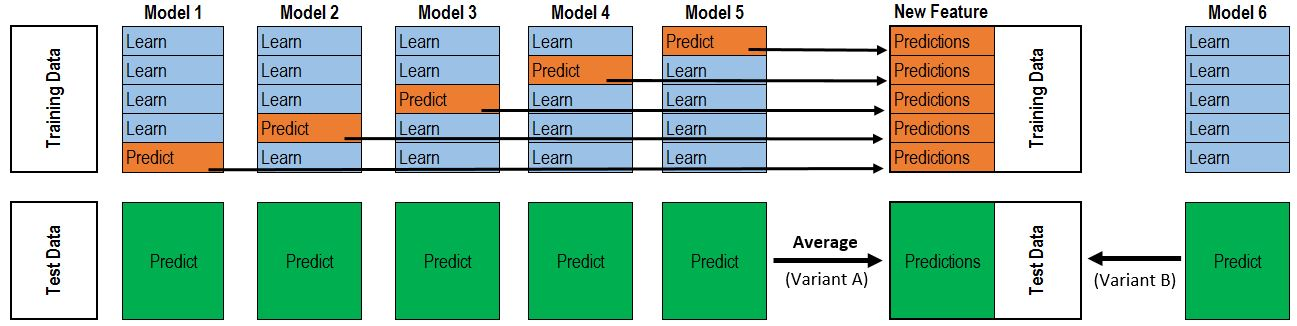

In [21]:
from IPython.display import Image

image_path = 'images/stacking.jpg'
Image(filename = image_path) 

(Taken from Linghao Zhang's post, [*How to Rank 10% in Your First Kaggle Competition*](https://dnc1994.com/2016/05/rank-10-percent-in-first-kaggle-competition-en/).  It's an interesting read for anyone curious to learn more about improving their scores in Kaggle competitions.  In fact, there is code to show you how it's done.  I struggled to wrap my head around stacking for a few days.  I read several articles on the approach, but I needed to see some code to understand what's going on behind the scenes.  Thanks Linghao!)

### How it Works

Starting from the far left, we pass in our training and test data to a series of base level models.  The base level models are labelled from Model 1-Model5.  Note that our final solution uses 7 models instead of 5.  Our training and test data are first fed to Model 1, then to Model 2 and so on.  For each model, we perform K-folds CV over the training set, and store the results/predictions on the validation set in a temp array.  For each model, we also get predictions from the entire test set, and also store these in a seperate array.  

After training the base models, we feed the predictions on the validation set as inputs into a level 1 model.  In the graph above, it shows that these predictions act like newly created features for this level 1 model.  At this stage, we also average the predictions on the test set, to create a new test set features.  At this point, we can train the level 1 model using the new features and then make predictions on the new test set.  

### Coding It

I'll create a class for this.  The entire process involves several steps, as discussed.  But let me outline the steps and then go into each in a bit more detail:

* First, initialize class attributes
* Create a method to handle the training of level 0 models 
* Create a method to handle the training of our level 1 model
* Create 3 different predict methods
    - One to make predictions on a trained neural network
    - The other to make predictions on trained XGBRegressor models
    - Lastly, one to make predictions on all other models (including random forests and extra trees regressors)

In [ ]:
# Declare class and create our constructor function
class Stacking():
    """Class constructor with attributes"""
    def __init__(self, X_train, y_train, X_test, base_models, stacked_model, folds):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.base_models = base_models
        self.stacked_model = stacked_model
        self.folds = folds

Here we declare our class, called `Stacking()`.  Then we create the `__init__()` method, or our constructor function.  This function gets called automatically when we create an instance of the class.  It takes in a few attributes as you can see.  These include our train and test sets, a list of our base models, our stacked model and the number of folds we will use during cross-validation.  These attributes are then transformed into class properties.  Meaning, we have access to them within the class.

In [ ]:
    def fit(self):
        """Train base models"""
        # create arrays to store results
        S_train = np.zeros((self.X_train.shape[0], len(self.base_models)))
        S_test = np.zeros((self.X_test.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            kf = KFold(n_splits = self.folds, shuffle = True, random_state = 2016)
            # Array to store test results per model
            S_test_i = np.zeros((self.X_test.shape[0], self.folds))
            
            for j, (train_index, val_index) in enumerate(kf.split(self.X_train)):  
                print("Begin training and testing base model on fold {}".format(j))
                print(model)
                start = time.time()
                
                X_train_mini, X_val = self.X_train.iloc[train_index], self.X_train.iloc[val_index]
                y_train_mini, y_val = self.y_train[train_index], self.y_train[val_index]
                
                # Train XGBoost Base Model
                if isinstance(model, xgb.sklearn.XGBModel):
                    model.fit(X_train_mini.values, 
                              y_train_mini, 
                              eval_metric = eval_error, 
                              eval_set = [(X_train_mini.values, y_train_mini), (X_val.values, y_val)], 
                              early_stopping_rounds = 100,
                              verbose = False)
                    
                    val_predictions, test_predictions = self.predict_xgb(model, X_val.values, y_val, j)
                    
                # Train Neural Network Base Model
                elif isinstance(model, keras.wrappers.scikit_learn.KerasRegressor):
                    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8)
                    model.fit(X_train_mini.values, 
                              y_train_mini, 
                              callbacks = [early_stopping], 
                              validation_data = (X_val.values, y_val), 
                              verbose = 2)
                    
                    val_predictions, test_predictions = self.predict_nn(model, X_val.values, y_val, j)
                
                else:
                    model.fit(X_train_mini.values, y_train_mini)
                    val_predictions, test_predictions = self.predict(model, X_val.values, y_val, j)
                    
                # Store predictions
                S_train[val_index, i] = val_predictions
                S_test_i[:, j] = test_predictions

                end = time.time()
                print("Training and testing on fold {} complete".format(j))
                print("Time elapsed: {} seconds \n".format(end - start))
            
            # Store avg test results
            S_test[:, i] = S_test_i.mean(axis = 1)
            # Save stacked data
            #np.savetxt(fname = "prepared_data/stacking/S_train.csv", X = S_train, delimiter=",")
            #np.savetxt(fname = "prepared_data/stacking/S_test.csv", X = S_test, delimiter=",")
        
        # Predict on Stacked Test Data
        final_predictions = self.fit_stacked(S_train, S_test)
        return final_predictions

We create and fill two numpy arrays with zeros, which will store our predictions on the validation and test sets.  The dimensions of these arrays are n x m where:
1. n is the length of the train or test sets
2. m is the number of base models

Then for each model, we perform K-Folds CV.  For each fold, we randomly shuffle the training data.  A temporary numpy array is created to store the test predictions after each fold.  This array is also n x m dimensions, similar to the two we created above.  

K-Folds partitions the training into smaller training sets to create validation sets.  Then we perform checks to see what type of model is being trained and handles each one accordingly.

Early stopping rounds is added to both the XGBRegressor and Neural Network to prevent overfitting.  After the model is trained over each fold, the predictions are stored in the arrays we created.  

In [ ]:
    def predict(self, model, X_val, y_val, j):
            # Predict on validation set 
            val_predictions = model.predict(X_val)
            error = mean_absolute_error(np.exp(y_val), np.exp(val_predictions))
            print("Error on fold {} is {}".format(j, error))

            # Predict on test set
            test_predictions = model.predict(self.X_test.values)
            return val_predictions, test_predictions 

I added three different predict methods.  The one above is able to make predictions on the Random Forest and Extra Trees Regressors.  The other predict methods are similar in layout, but has added functionality for the XGBRegessor and Neural Network models to work. The method handles predictions on both validation and test sets.  

In [ ]:
    def fit_stacked(self, S_train, S_test):
            print("Begin training L1 model")
            # Train stacked model on entire train set
            self.stacked_model.fit(S_train, self.y_train)
            # Use S_test as inputs to this trained model
            return np.exp(self.stacked_model.predict(S_test)) - shift

After all the base models are trained, we call the `fit_stacked()` method to train the level 1 model.  It returns our final output that can be used as part of our submission to Kaggle.  

Here is all the code for the class:

In [25]:
class Stacking():
    """Class constructor with attributes"""
    def __init__(self, X_train, y_train, X_test, base_models, stacked_model, folds):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.base_models = base_models
        self.stacked_model = stacked_model
        self.folds = folds
    
    def fit(self):
        """Train base models"""
        # create arrays to store results
        S_train = np.zeros((self.X_train.shape[0], len(self.base_models)))
        S_test = np.zeros((self.X_test.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            
            kf = KFold(n_splits = self.folds, shuffle = True, random_state = 2016)
            # Array to store test results per model
            S_test_i = np.zeros((self.X_test.shape[0], self.folds))
            
            for j, (train_index, val_index) in enumerate(kf.split(self.X_train)):
                print("Begin training and testing base model {} on fold {}".format(i, j))
                start = time.time()
                
                X_train_mini, X_val = self.X_train.iloc[train_index], self.X_train.iloc[val_index]
                y_train_mini, y_val = self.y_train[train_index], self.y_train[val_index]
                
                # Train XGBoost Base Model
                if isinstance(model, xgb.sklearn.XGBModel):
                    model.fit(X_train_mini.values, 
                              y_train_mini, 
                              eval_metric = eval_error, 
                              eval_set = [(X_train_mini.values, y_train_mini), (X_val.values, y_val)], 
                              early_stopping_rounds = 100,
                              verbose = False)
                    
                    val_predictions, test_predictions = self.predict_xgb(model, X_val.values, y_val, j)
                    
                # Train Neural Network Base Model
                elif isinstance(model, keras.wrappers.scikit_learn.KerasRegressor):
                    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8)
                    model.fit(X_train_mini.values, 
                              y_train_mini, 
                              callbacks = [early_stopping], 
                              validation_data = (X_val.values, y_val), 
                              verbose = 0)
                    
                    val_predictions, test_predictions = self.predict_nn(model, X_val.values, y_val, j)
                
                else:
                    model.fit(X_train_mini.values, y_train_mini)
                    val_predictions, test_predictions = self.predict(model, X_val.values, y_val, j)
                # Store predictions
                S_train[val_index, i] = val_predictions
                S_test_i[:, j] = test_predictions

                end = time.time()
                print("Training and testing on fold {} complete".format(j))
                print("Time elapsed: {} seconds \n".format(end - start))
            
            # Store avg test results
            S_test[:, i] = S_test_i.mean(axis = 1)
            # Save stacked data
            #np.savetxt(fname = "prepared_data/stacking/S_train.csv", X = S_train, delimiter=",")
            #np.savetxt(fname = "prepared_data/stacking/S_test.csv", X = S_test, delimiter=",")
        
        # Predict on Stacked Test Data
        final_predictions = self.fit_stacked(S_train, S_test)
        return final_predictions
    
    def fit_stacked(self, S_train, S_test):
        print("Begin training L1 model")
        # Train stacked model on entire train set
        self.stacked_model.fit(S_train, self.y_train)
        # Use S_test as inputs to this trained model
        return np.exp(self.stacked_model.predict(S_test)) - shift

    def predict(self, model, X_val, y_val, j):
        # Predict on validation set 
        val_predictions = model.predict(X_val)
        error = mean_absolute_error(np.exp(y_val), np.exp(val_predictions))
        print("Error on fold {} is {}".format(j, error))
        
        # Predict on test set
        test_predictions = model.predict(self.X_test.values)
        return val_predictions, test_predictions 
        
    def predict_xgb(self, model, X_val, y_val, j):
        # Predict on validation set 
        val_predictions = model.predict(X_val, ntree_limit = model.best_ntree_limit)
        error = mean_absolute_error(np.exp(y_val), np.exp(val_predictions))
        print("Error on fold {} is {}".format(j, error))
        
        # Predict on test set
        test_predictions = model.predict(self.X_test.values, ntree_limit = model.best_ntree_limit)
        return val_predictions, test_predictions
        
    def predict_nn(self, model, X_val, y_val, j):
        # Predict on validation set 
        val_predictions = model.predict(X_val, batch_size = 128, verbose = 0)
        error = mean_absolute_error(np.exp(y_val), np.exp(val_predictions))
        print("Error on fold {} is {}".format(j, error))
        
        # Predict on test set
        test_predictions = model.predict(self.X_test.values, batch_size = 128, verbose = 0)
        return val_predictions, test_predictions

### Stacking Models

Below, I initialize instances of all the models to be used.  

In [44]:
# Necessary imports for Estimators  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

# Necessary imports for Neural network
from keras.models import Sequential
import keras
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU

Using TensorFlow backend.


For the neural network, we will use the Keras API, built on top of a Tensorflow backend.  Keras makes it very easy to construct neural networks.  I will walk you through creating a small neural network after creating instances for the estimators.

## Models

In [15]:
# initialize Gradient Boosting Regressor
gbr = GradientBoostingRegressor(learning_rate = 0.05, 
                                    max_depth = 7, 
                                    max_features = 0.63, 
                                    n_estimators = 500, 
                                    verbose = 0,
                                    random_state = 2016)

# initialize Random Forest
rfr=RandomForestRegressor(n_jobs = -1, 
                            verbose = 0, 
                            random_state = 2016, 
                            n_estimators = 40,
                            max_features = 13)

# initialize Extra Trees Regressor
etr = ExtraTreesRegressor(n_jobs = -1, 
                            verbose = 0,
                            max_depth = 30,
                            random_state = 2016, 
                            n_estimators = 100,
                            max_features = 'sqrt')

# 1st XGBRegressor
xgb1 = XGBRegressor(learning_rate = 0.01,
                         n_estimators = 30000,
                         max_depth = 12,
                         min_child_weight = 1,
                         gamma = 1,
                         subsample = 0.8,
                         colsample_bytree = 0.5,
                         seed=2016,
                         reg_alpha = 1.0,
                         silent = True)

# 2nd XGBRegressor
xgb2 = XGBRegressor(learning_rate = 0.01,
                     n_estimators = 30000,
                     max_depth = 7,
                     min_child_weight = 8,
                     gamma = 1,
                     subsample = 0.9,
                     colsample_bytree = 0.5,
                     seed=2016,
                     reg_alpha = 1.0,
                     silent = True)

# 3rd XGBRegressor
xgb3 = XGBRegressor(learning_rate = 0.01,
                     n_estimators = 30000,
                     max_depth = 6,
                     min_child_weight = 5,
                     gamma = .2,
                     subsample = 0.7,
                     colsample_bytree = 0.5,
                     seed=2016,
                     reg_alpha = 1.0,
                     silent = True)

# initialize Linear Regression
lr = LinearRegression()

Now onto creating our neural network.  For this step, I used a neural net implemented in this [kernel](https://www.kaggle.com/mtinti/allstate-claims-severity/keras-starter-with-bagging-1111-84364). 

### Neural Network Architecture

In [16]:
def create_neural_network():
    model = Sequential()
    model.add(Dense(400, input_dim = 130, init = 'he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(200, init = 'he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())    
    model.add(Dropout(0.2))

    model.add(Dense(50, init = 'he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())    
    model.add(Dropout(0.2))

    model.add(Dense(1, init = 'he_normal'))
    model.compile(loss = 'mae', optimizer = 'adadelta')
    return model

In [27]:
# initialize neural network
mlp = KerasRegressor(build_fn = create_neural_network, 
                         nb_epoch = 2000, 
                         batch_size = 128, 
                         verbose=0)

The neural network has a sequential stack of 4 layers.  The first layer has input dimensions equal to the number of features found in our training set, 130.  Weights in all layers are gaussian initialized.  We add dropout to prevent overfitting.  Notice that each layer except the last consists of a fully-connected layer(dense), a PreLU, Batchnormalization and dropout.  The PreLu is an activation function.  The batchnormalization normalizes the activations of the previous layer.  After creating the layers, we declare the loss function and set our optimizer.  

What we have here is a Multilayer Perceptron(MLP), a feedforward neural network.  Feedforward means that information flows in one direction, from the input layer to the output layers.  The MLP is a fully-connected network of neurons.  This means that the inputs to each layer is connected to the outputs of the previous connected layer.  

MLPs first assign weights to each input.  In our case, the inputs refer to the 130 features found in each row(claim).  These inputs are considered the neurons that we initialize in the input layer.  MLPs learn by updating the value of these weights over a number of epochs to reflect the strength of the connection that each input has on the outputs in each layer.  Neurons with stronger connections will be activated by our PReLU function, while weaker connections will often times be ignored.  

Like any machine learning algorithm, we have an objective function that we want to optimize.  In our case, we are using an `adadelta` optimizer.  The adadelta function works by gradually adapting over time, especially around periods of local minima.  It can adjust the learning rate automatically to speed up or slow down learning, depending on whether we are approaching local minima.  

If you want to learn more about neural networks, see [Michael Nielsen's free online book](http://neuralnetworksanddeeplearning.com/index.html). 

We can now attempt to train the ensemble using the `Stacking()` class we defined earlier.

In [28]:
# ensemble base models 
base_models = [mlp, gbr, xgb3, rfr, etr, xgb1, xgb2] 

start = time.time()
# train ensemble
predictions = Stacking(X_train, y_train, X_test, base_models, stacked_model = lr, folds = k).fit()

# save predictions
save_predictions(ids = test_ids, predictions = predictions, filepath = "submissions/stacked.csv")
end = time.time()

print("Total Time elapsed: {} seconds".format(end - start))

Begin training and testing base model 0 on fold 0
Error on fold 0 is 1184.4828706722858
Training and testing on fold 0 complete
Time elapsed: 1680.6351218223572 seconds 

Begin training and testing base model 0 on fold 1
Error on fold 1 is 1183.3179104374422
Training and testing on fold 1 complete
Time elapsed: 1001.0095889568329 seconds 

Begin training and testing base model 0 on fold 2
Error on fold 2 is 1193.4925901997321
Training and testing on fold 2 complete
Time elapsed: 1053.6155080795288 seconds 

Begin training and testing base model 0 on fold 3
Error on fold 3 is 1218.7273285076594
Training and testing on fold 3 complete
Time elapsed: 640.5740990638733 seconds 

Begin training and testing base model 0 on fold 4
Error on fold 4 is 1200.6089171615554
Training and testing on fold 4 complete
Time elapsed: 1417.2522649765015 seconds 

Begin training and testing base model 1 on fold 0
Error on fold 0 is 1141.602325769953
Training and testing on fold 0 complete
Time elapsed: 1076.

Training complete! The file is also ready to be submitted to Kaggle.  Notice it took over six hours to train this relatively small ensemble on my local computer.  

Submitting this file yields a score of roughly 1126.05 on the private leaderboard.  This is an improvement on the first submission that yielded around 1129.75.  We did a lot to get a 3.5 point improvement.  

From the printed results, we see that the neural network, random forest and extra trees models didn't do so well.  The XGBoost models and the Gradient Boosting Regressor achieved validation errors ranging between 1128-1150.  

So why use the weaker models?  Because the weaker models could possibly learn something different about the data.  It may be more fruitful to opt for non-tree based models to see how they could improve our score.  

## Conclusion

Well there you have it.  We now have a working solution that produced fairly good results.  And we see how an ensemble of models performed better than stand-alone models.  

After the competition ended, several top performers were kind enough to share their approach.  What I learned was that they used more complex stacking archtectures, with more models in the base level and level 1 layers.  Some even used a 3rd layer on top of that.  Some also performed various feature transformations and then trained models on these, before including them in the ensemble.

Here are some links to the [1st place](https://www.kaggle.com/c/allstate-claims-severity/forums/t/26416/1st-place-solution), [2nd place](https://www.kaggle.com/c/allstate-claims-severity/forums/t/26427/2nd-place-solution) and [12th place](https://www.kaggle.com/c/allstate-claims-severity/forums/t/26414/12th-place-solution) solutions.  

So where does that leave us?  Well, we could take this project to another level and implement what we learned from other Kagglers.  But let's keep in mind the added computational cost by doing this.  Below is list of things we could try:

* Add more models to the ensemble
* Add a 3rd level to the ensemble
* Considering adding SVMs, K-NNs, pyLightGBM, ElasticNet
* power, sqrt, log transformations
